In [16]:
import math
import audiolazy as al
import pyaudio as pa
import pygame
import numpy as np
import matplotlib.pyplot as pypl
from midiutil import MIDIFile

In [17]:
#Import primary functions ---------------------------------------------------------------------

def playlist(freq, timestep,sampling):
    #Accepts a list of frequencies and plays them with timestep lag
    # Setup ----------------------
    rate = sampling
    s, Hz = al.sHz(rate)
    ms = 1e-3 * s
    # Note queue -----------------
    note_init = al.karplus_strong(int(freq[0]) * Hz)
    notes = note_init
    for i in range(1,len(freq)):
        notes += al.zeros(timestep * i * ms).append(al.karplus_strong(freq[i] * Hz))
    notes *= 0.5
    sound = notes.take(10 * s)
    with al.AudioIO(True) as player: # True means "wait for all sounds to stop"
        player.play(sound, rate=rate)

# Difference between playlist() and playlistChords()
# playlistChords accepts multiple karplus_strings at the same time (nested array)
def playlistChords(freq, timestep, sampling):
    #Accepts a list of same-time frequencies and plays them with timestep lag
    # Setup ----------------------
    rate = int(sampling)
    s, Hz = al.sHz(rate)
    ms = 1e-3 * s
    # Note queue -----------------
    note_init = al.karplus_strong(int(freq[0]) * Hz)
    notes = note_init
    
    for i in range(1,len(freq)):
        if isinstance(freq[i],list) == True:
            for j in range(len(freq[i])):
                notes += al.zeros(timestep * i * ms + j * ms).append(al.karplus_strong(freq[i][j] * Hz))
        else:
            notes += al.zeros(timestep * i * ms).append(al.karplus_strong(freq[i] * Hz))
    
    notes *= 0.5
    sound = notes.take(10 * s)
    with al.AudioIO(True) as player: # True means "wait for all sounds to stop"
        player.play(sound, rate=rate)
    
    #Example: playlistChords([300,[440,880],400,500,[400,800,1200,1600]],300,31415)

def applyMapping(data,ranges,equ): #equ = 1 for EquationMapping, 0 for not
    data_init = data
    if equ == 1:
        data = [1/(1+math.e**-i) for i in data] # <------- Feel free to change this equation
    #Don't mess with this line:
    datrange = max(data)-min(data)
    extrange = ranges[1]-ranges[0]
    
    data = [((x-min(data))/datrange)*extrange+ranges[0] for x in data]
    
    if equ == 1:
        import matplotlib.pyplot as pypl
        pypl.plot([x for x in data_init],data)
        pypl.ylabel('Frequency in Hz')
        pypl.xlabel('x value in equation')
        pypl.show()
    return data

def toMultiMIDI(data,bpm,filename,n_tracks):
    def nearestNested(dat):
        #takes frequency data and converts it to the nearest midi key
        #uses formula from "The Glass Armonica" (URL earlier in code)
        mids = [[int((12/math.log(2))*math.log(y/27.5)+21) for y in x] for x in dat]
        return mids
    
    degrees = nearestNested(data)
    channel = 0
    time = 0
    duration = 1
    tempo = bpm
    volume = 100
    
    MyMIDI = MIDIFile(n_tracks)
    
    for x in range(n_tracks):
        MyMIDI.addTempo(x,time,tempo)
    
    for i, pitch in enumerate(degrees):
        for j in range(n_tracks):
            MyMIDI.addNote(j, channel, pitch[j], time + i, duration, volume)
    
    with open(filename, 'wb') as output_file:
        MyMIDI.writeFile(output_file)

def playMIDI(filename):
    pygame.mixer.init(31415,-16,1,1024) #Playback rate, bit type, ??, buffer
    
    clock = pygame.time.Clock()
    pygame.mixer.music.load(filename)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy(): #Checks if playback finished
        clock.tick(30)

def samples(num): #Pick a number between 1 and x
    #Production of dataset: -------------------------------------
    if num == 1: #Demonstrates equation listening
        funcvals = applyMapping(range(-20,20),[200,1500],1)
        playlist(funcvals,200,31415)
    if num == 2: #Demonstrates MIDI writing and playback
        funcvals = applyMapping(range(-20,20),[200,1500],1)
        toMultiMIDI([[x] for x in funcvals],400,'temp_sample.mid',1)
        playMIDI('temp_sample.mid')
    if num == 3: #Demonstrates basic rising notes
        print('Rising notes...')
        playlist(rising_piano,200,31415)
    if num == 4: #Demonstrates multi-layer MIDI
        toMultiMIDI([[x,128-x] for x in range(21,108,2)],300,'temp_sample.mid',2)
        playMIDI('temp_sample.mid')

In [18]:
conversions = [['21', 'A0', '27.5'],
                ['22', 'A#0', '29.1'],
                ['23', 'B0', '30.9'],
                ['24', 'C1', '32.7'],
                ['25', 'C#1', '34.6'],
                ['26', 'D1', '36.7'],
                ['27', 'D#1', '38.9'],
                ['28', 'E1', '41.2'],
                ['29', 'F1', '43.7'],
                ['30', 'F#1', '46.2'],
                ['31', 'G1', '49.0'],
                ['32', 'G#1', '51.9'],
                ['33', 'A1', '55.0'],
                ['34', 'A#1', '58.3'],
                ['35', 'B1', '61.7'],
                ['36', 'C2', '65.4'],
                ['37', 'C#2', '69.3'],
                ['38', 'D2', '73.4'],
                ['39', 'D#2', '77.8'],
                ['40', 'E2', '82.4'],
                ['41', 'F2', '87.3'],
                ['42', 'F#2', '92.5'],
                ['43', 'G2', '98.0'],
                ['44', 'G#2', '103.8'],
                ['45', 'A2', '110.0'],
                ['46', 'A#2', '116.5'],
                ['47', 'B2', '123.5'],
                ['48', 'C3', '130.8'],
                ['49', 'C#3', '138.6'],
                ['50', 'D3', '146.8'],
                ['51', 'D#3', '155.6'],
                ['52', 'E3', '164.8'],
                ['53', 'F3', '174.6'],
                ['54', 'F#3', '185.0'],
                ['55', 'G3', '196.0'],
                ['56', 'G#3', '207.7'],
                ['57', 'A3', '220.0'],
                ['58', 'A#3', '233.1'],
                ['59', 'B3', '246.9'],
                ['60', 'C4', '261.6'],
                ['61', 'C#4', '277.2'],
                ['62', 'D4', '293.7'],
                ['63', 'D#4', '311.1'],
                ['64', 'E4', '329.6'],
                ['65', 'F4', '349.2'],
                ['66', 'F#4', '370.0'],
                ['67', 'G4', '392.0'],
                ['68', 'G#4', '415.3'],
                ['69', 'A4', '440.0'],
                ['70', 'A#4', '466.2'],
                ['71', 'B4', '493.9'],
                ['72', 'C5', '523.3'],
                ['73', 'C#5', '554.4'],
                ['74', 'D5', '587.3'],
                ['75', 'D#5', '622.3'],
                ['76', 'E5', '659.3'],
                ['77', 'F5', '698.5'],
                ['78', 'F#5', '740.0'],
                ['79', 'G5', '784.0'],
                ['80', 'G#5', '830.6'],
                ['81', 'A5', '880.0'],
                ['82', 'A#5', '932.3'],
                ['83', 'B5', '987.8'],
                ['84', 'C6', '1046.5'],
                ['85', 'C#6', '1108.7'],
                ['86', 'D6', '1174.7'],
                ['87', 'D#6', '1244.5'],
                ['88', 'E6', '1318.5'],
                ['89', 'F6', '1396.9'],
                ['90', 'F#6', '1480.0'],
                ['91', 'G6', '1568.0'],
                ['92', 'G#6', '1661.2'],
                ['93', 'A6', '1760.0'],
                ['94', 'A#6', '1864.7'],
                ['95', 'B6', '1975.5'],
                ['96', 'C7', '2093.0'],
                ['97', 'C#7', '2217.5'],
                ['98', 'D7', '2349.3'],
                ['99', 'D#7', '2489.0'],
                ['100', 'E7', '2637.0'],
                ['101', 'F7', '2793.8'],
                ['102', 'F#7', '2960.0'],
                ['103', 'G7', '3136.0'],
                ['104', 'G#7', '3322.4'],
                ['105', 'A7', '3520.0'],
                ['106', 'A#7', '3729.3'],
                ['107', 'B7', '3951.1'],
                ['108', 'C8', '4186.0']]
rising_piano = [float(x[2]) for x in conversions][50:70]

In [19]:
samples(4)

C:\Users\Syris Norelli\Anaconda3\lib\site-packages\midiutil\MidiFile.py:899: FutureWarning: Please explicitly set adjust_origin. Default behaviour will change in a future version.
  FutureWarning)


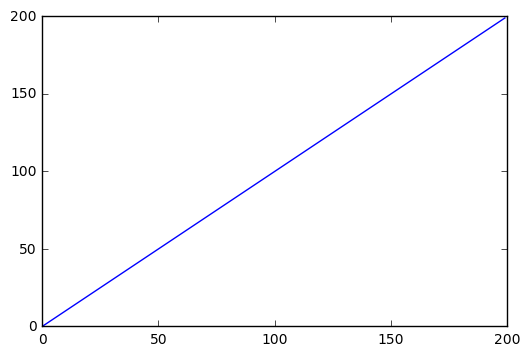

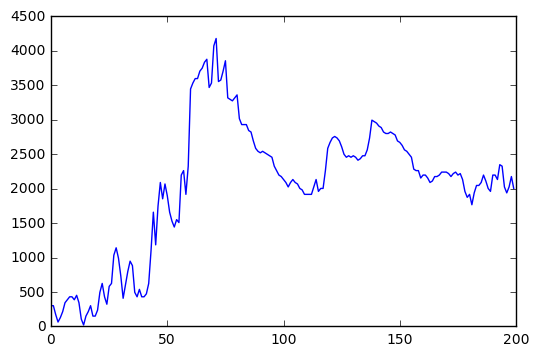

C:\Users\Syris Norelli\Anaconda3\lib\site-packages\midiutil\MidiFile.py:899: FutureWarning: Please explicitly set adjust_origin. Default behaviour will change in a future version.
  FutureWarning)


In [20]:
#Presentation stuff ------------------------------------------------------------------
precip_data = np.loadtxt('AvgPrecipation.txt').tolist()
temperature_data = np.loadtxt('MaxTemperature.txt').tolist()
humidity_data = np.loadtxt('AvgHumidity.txt').tolist()

def final(temp):
    #Before mapping
    temp = [x if x != -9999 else 0 for x in temp] # Removing unknown data
    pypl.plot([x for x in range(len(temp))],temp)
    pypl.show()
    
    #After mapping
    temp = applyMapping(temp,[21,4180],0)
    pypl.plot([x for x in range(len(temp))],temp)
    pypl.show()
    
    temp = [[x] for x in temp] #Formatting for toMultiMIDI function
    
    toMultiMIDI(temp,200,'final_weather.mid',1) #data, bpm, filename, tracks
    playMIDI('final_weather.mid')

final(temperature_data[:200])